In [1]:
# Load data from MySQL to perform exploratory data analysis
import settings
import mysql.connector
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


db_connection = mysql.connector.connect(
    host="localhost",
    user="root",
    passwd="password",
    database="TwitterDB",
    charset = 'utf8'
)

Airbnb Negative Tweets Monitor: 
  2019-08-06 22:22:41  i hate a "no smoking, parties, or events" ass airbnb bitch thats why we there
  2019-08-06 22:22:58  RT @MeDicenPolola: #1: Maldita gentrificacin :( 
#2: Uuuuurrrrge regulacin de los AirBnB https://t.co/Kt6ZQVJaVU
  2019-08-06 22:26:39  Bro these mfs mad over a paint job...
  2019-08-06 22:32:47  It's.... it looks embarrassing.  What's wrong with using words?
  2019-08-06 22:39:03  Somebody lets rent an AIRBNB &amp; play Bad Girls Club
  2019-08-06 22:54:15  RT @NyreeUnique: I want to rent a AIRBNB and get some girls and play bad girls club 
  2019-08-06 22:59:54  @w0rd2dawn Yep Ill pay for the hotel or Airbnb
  2019-08-06 23:01:56  interviews at amazon are now so insane and unlike any engineering position on the planet that you can now take a "p https://t.co/NAuFeGlj3V
  2019-08-06 23:04:51  Somebody lets rent an AIRBNB  &amp; play Bad Girls Club  edition
  2019-08-06 23:08:32  Are we seriously such a pathetic society that we com

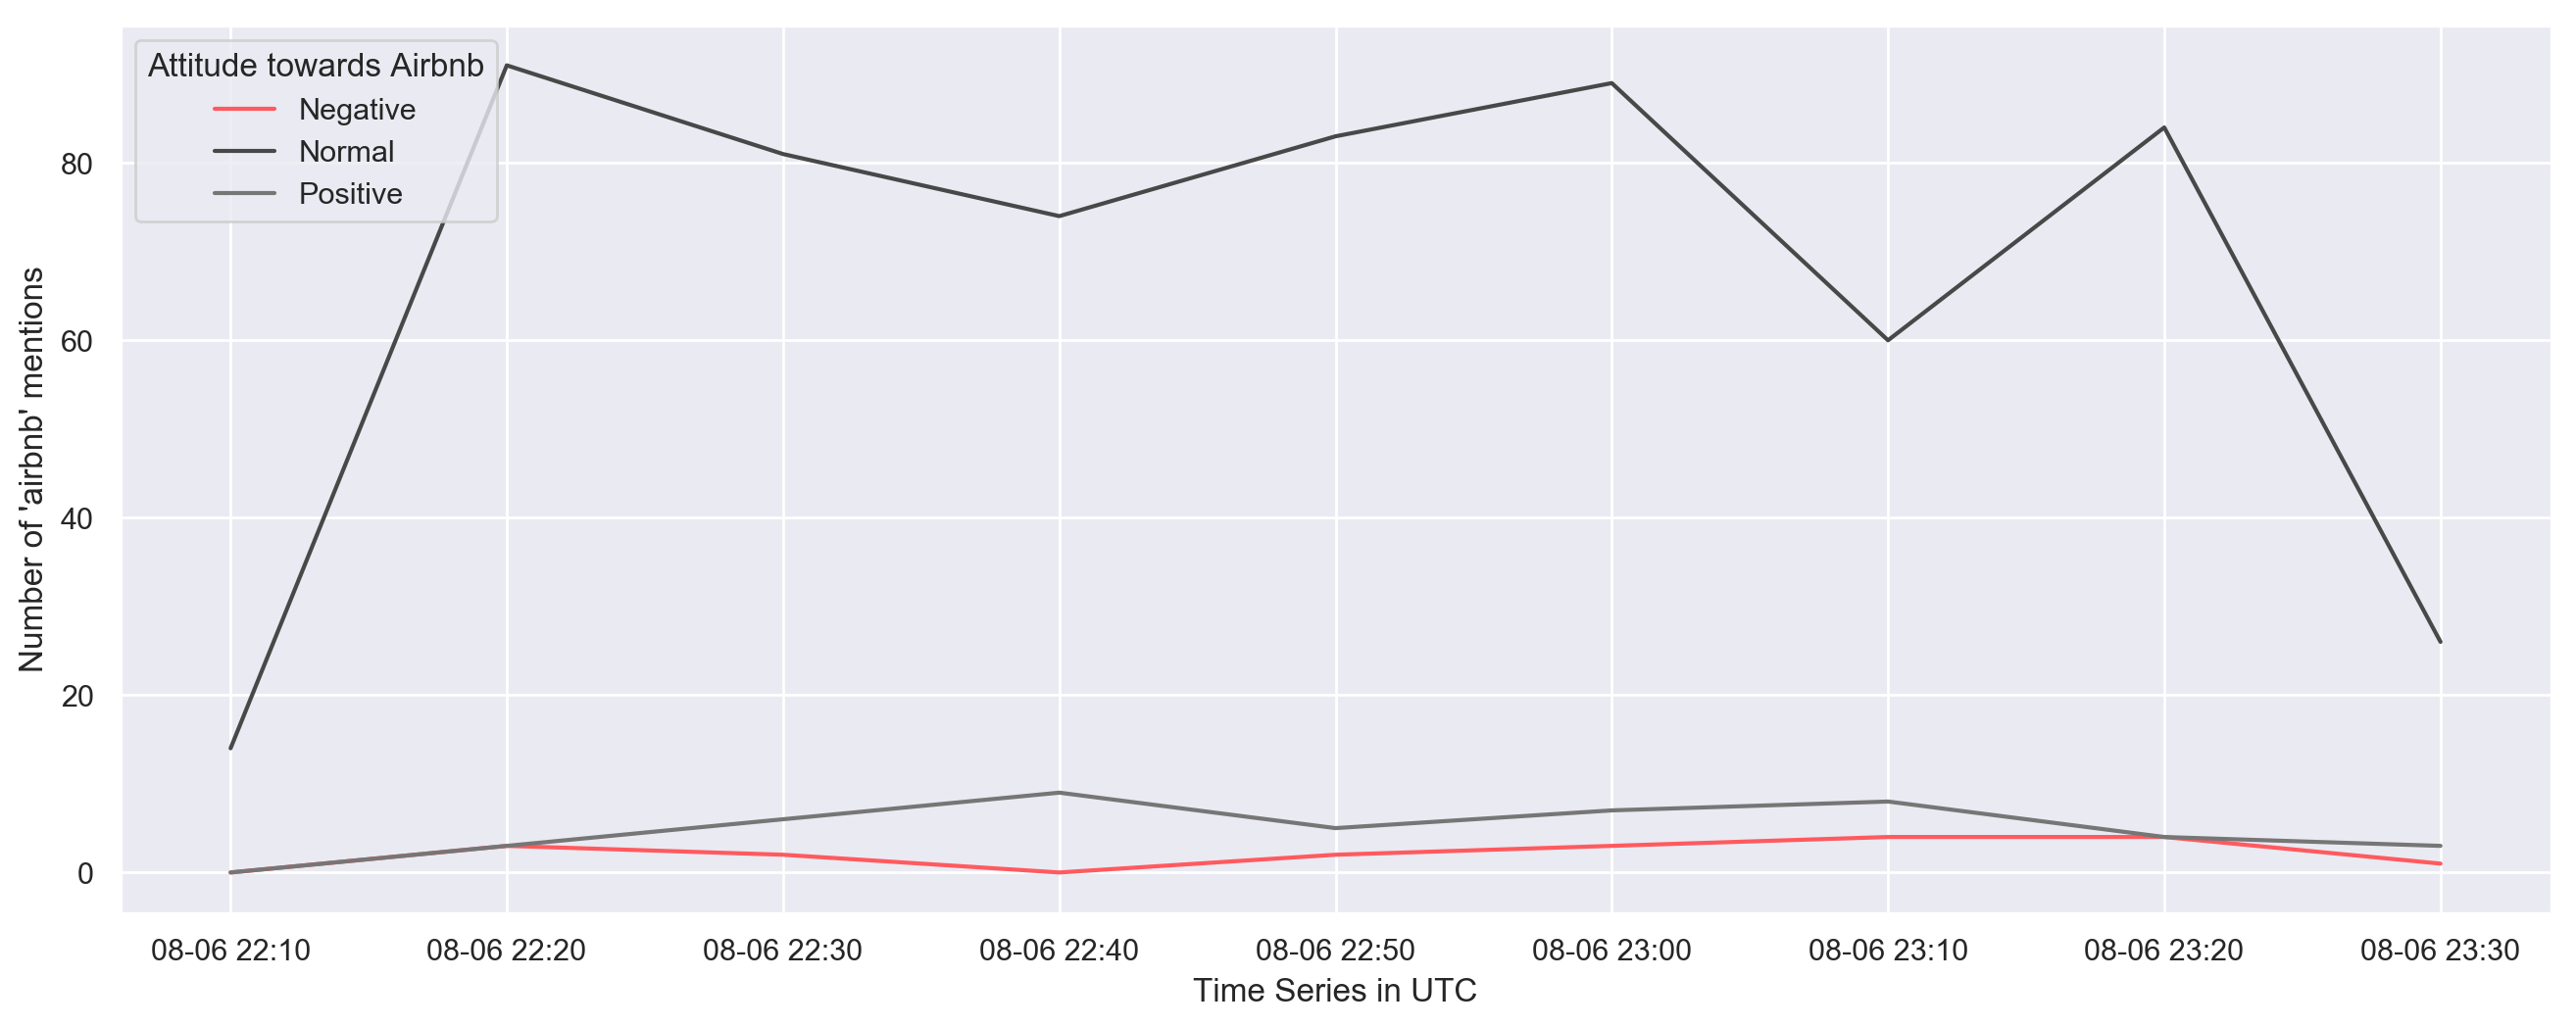

In [4]:
# Load data from MySQL
df = pd.read_sql('SELECT id_str, text, created_at, polarity FROM {}'.format(settings.TABLE_NAME), con=db_connection)
# UTC for date time at default
df['created_at'] = pd.to_datetime(df['created_at'])
print("Airbnb Negative Tweets Monitor: ")
for index, tweets in df[df['polarity'] == -1].iterrows():
    print("  " +str(tweets[2]) + "  " + tweets[1])


# Clean and transform data to enable time series
result = df.groupby([pd.Grouper(key='created_at', freq='10min'), 'polarity']).count() \
        .unstack(fill_value=0).stack().reset_index()
result['created_at'] = pd.to_datetime(result['created_at']).apply(lambda x: x.strftime('%m-%d %H:%M'))


# Plot Line Chart for monitoring brand awareness on Twitter
mpl.rcParams['figure.dpi']= 200
plt.figure(figsize=(16, 6))
sns.set(style="darkgrid")
ax = sns.lineplot(x = "created_at" ,y="id_str", hue='polarity', data=result,\
                  palette=sns.color_palette(["#FF5A5F","#484848", "#767676"]))
ax.set(xlabel='Time Series in UTC', ylabel="Number of '{}' mentions".format(settings.TRACK_WORDS[0]))
plt.legend(title='Attitude towards Airbnb', loc='upper left', labels=['Negative', 'Normal', 'Positive'])
sns.set(rc={"lines.linewidth": 1})
plt.show()